In [1]:
import os
import time

import nbimporter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
     accuracy_score, auc,
     classification_report,
     confusion_matrix, 
     f1_score,
     precision_score,
     recall_score,
     roc_curve)

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE

from data_processing import (
    load_dataset,
    get_samples_by_label,
    combine_datasets,
    calculate_label_distribution,
    display_label_distribution,
    display_unique_labels,
    display_dataset_length,
    delete_duplicates,
    imputation_missing_number_values,
    map_label,
    generate_smoth_samples,
    trim_datataset
)

from data_visualize import (
    visualize_labels,
    show_importances_feature,
    extract_important_features,
    check_missing_values,
    time_execution,
    visualizationMetrics,
    plot_confusion_matrix,
    visualize_model_accuracies,
    visualize_model_metrics,
    visualize_model_probabilities,
    plot_roc_curve
)

In [2]:
files_relative_path = 'data2/'
files_names = ['LDAP.csv', 'MSSQL.csv', 'NetBIOS.csv', 'Portmap.csv', 'Syn.csv', 'UDP.csv', 'UDPLag.csv']

In [3]:
combined_df = combine_datasets(files_relative_path, files_names, nrows=100000)

In [4]:
combined_df.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,13605,172.16.0.5-192.168.50.4-870-2908-17,172.16.0.5,870,192.168.50.4,2908,17,2018-11-03 10:09:00.565557,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
1,62631,172.16.0.5-192.168.50.4-871-53796-17,172.16.0.5,871,192.168.50.4,53796,17,2018-11-03 10:09:00.565559,48,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
2,143869,172.16.0.5-192.168.50.4-648-40660-17,172.16.0.5,648,192.168.50.4,40660,17,2018-11-03 10:09:00.565608,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
3,16171,172.16.0.5-192.168.50.4-872-54308-17,172.16.0.5,872,192.168.50.4,54308,17,2018-11-03 10:09:00.565993,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
4,80845,172.16.0.5-192.168.50.4-873-40653-17,172.16.0.5,873,192.168.50.4,40653,17,2018-11-03 10:09:00.565994,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS


In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 88 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   700000 non-null  int64  
 1   Flow ID                      700000 non-null  object 
 2   Source IP                    700000 non-null  object 
 3   Source Port                  700000 non-null  int64  
 4   Destination IP               700000 non-null  object 
 5   Destination Port             700000 non-null  int64  
 6   Protocol                     700000 non-null  int64  
 7   Timestamp                    700000 non-null  object 
 8   Flow Duration                700000 non-null  int64  
 9   Total Fwd Packets            700000 non-null  int64  
 10  Total Backward Packets       700000 non-null  int64  
 11  Total Length of Fwd Packets  700000 non-null  float64
 12  Total Length of Bwd Packets  700000 non-null  float64
 13 

In [6]:
display_unique_labels(combined_df)
display_dataset_length(combined_df)

Unique Labels: ['NetBIOS' 'BENIGN' 'LDAP' 'MSSQL' 'Portmap' 'Syn' 'UDP']
Dataset length: 700000


In [7]:
label_distribution = calculate_label_distribution(combined_df, 'Label')

display_label_distribution(label_distribution)

Samples Count: NetBIOS: 199899
Percentage distribution of data: NetBIOS: 28.56%
Samples Count: UDP: 173865
Percentage distribution of data: UDP: 24.84%
Samples Count: MSSQL: 114054
Percentage distribution of data: MSSQL: 16.29%
Samples Count: Syn: 99978
Percentage distribution of data: Syn: 14.28%
Samples Count: Portmap: 95273
Percentage distribution of data: Portmap: 13.61%
Samples Count: LDAP: 9931
Percentage distribution of data: LDAP: 1.42%
Samples Count: BENIGN: 7000
Percentage distribution of data: BENIGN: 1.00%


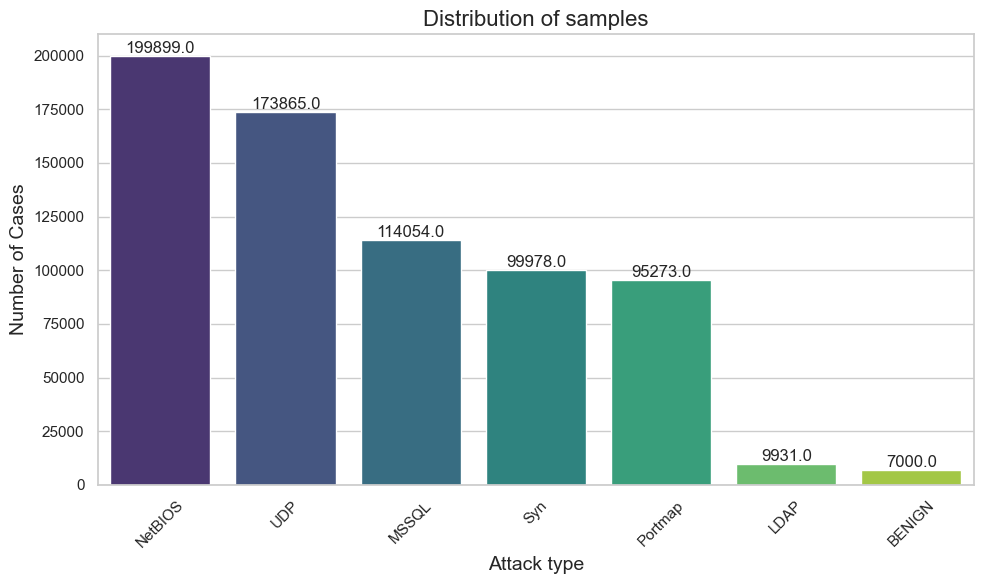

In [8]:
visualize_labels(combined_df)

Drops and Renames
Some columns are not intended for use because they are metadata. Flow ID, IP addresses, timestamps, etc.

If you are unsure why source and destination port are also removed you can read Establishing the Contaminating Effect of Metadata Feature Inclusion in Machine-Learned Network Intrusion Detection Models.. In short: any included metadata feature will act as a (very) powerful shortcut predictor.

Metadata features
Metadata features are information that is not directly related to the problem being analyzed, but may contain relevant contextual data. In the case of DDoS attack detection, such features may include:
Flow ID: a unique identifier for each network flow.
IP addresses: source and destination IP addresses can be used to identify attackers or victims.
Timestamps: timestamps can help identify when an attack took place.
Contamination of the model
Incorporating these features into a model can lead to what is known as model contamination, meaning that the model can learn to rely on these easy-to-predict features instead of the more complex patterns associated with DDoS attacks.

For example:
The model may learn that certain IP addresses are always associated with attacks, which can lead to erroneous conclusions for new, unfamiliar addresses.
Conclusion
The author suggests that removing such metadata features from training data can improve the quality of the model. This will force the model to focus on more relevant features related to attacks, which should improve its ability to generalize and be effective in detecting real attacks.
Agree with the hint
I agree with this approach. In the context of DDoS attack detection:
Complexity of the problem: Models should be trained on features that actually reflect the behavior of attacks, rather than on simple metadata indicators.
Generalization: Removing metadata features helps create models that better rad

# Data Preprocessing

In [9]:
drop_columns = [
    "Flow ID",
    'Fwd Header Length.1',
    "Source IP", "Src IP",
    "Source Port", "Src Port",
    "Destination IP", "Dst IP",
    "Destination Port", "Dst Port",
    "Timestamp",
    "Unnamed: 0", "Inbound", "SimillarHTTP"
]

combined_df = combined_df.drop(columns=drop_columns, errors='ignore', axis=1)

# Verify removal columns
len(combined_df.columns)

78

In [10]:
check_missing_values(combined_df)

=== Kolumny z brakującymi wartościami ===
Kolumna: Flow Bytes/s - 8 brakujących wartości - (0.00% danych)


Dropping duplicates
There should be no duplicates because they can bias training and can lead
to over-optimistic estimates of classification performance during testing.

In [11]:
combined_df = delete_duplicates(combined_df)

display_dataset_length(combined_df)

547445 fully duplicate rows to remove
(152555, 78)
Dataset length: 152555


In [12]:
combined_df = imputation_missing_number_values(combined_df)

Imputation median in 2 columns.
Deleted 0 columns


In [13]:
combined_df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,17,1,2,0,422.0,0.0,211.0,211.0,211.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS
1,17,48,2,0,530.0,0.0,265.0,265.0,265.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS
2,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS
3,17,1,2,0,494.0,0.0,247.0,247.0,247.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS
4,17,2,2,0,494.0,0.0,247.0,247.0,247.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS


In [14]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152555 entries, 0 to 152554
Data columns (total 78 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Protocol                     152555 non-null  int64  
 1   Flow Duration                152555 non-null  int64  
 2   Total Fwd Packets            152555 non-null  int64  
 3   Total Backward Packets       152555 non-null  int64  
 4   Total Length of Fwd Packets  152555 non-null  float64
 5   Total Length of Bwd Packets  152555 non-null  float64
 6   Fwd Packet Length Max        152555 non-null  float64
 7   Fwd Packet Length Min        152555 non-null  float64
 8   Fwd Packet Length Mean       152555 non-null  float64
 9   Fwd Packet Length Std        152555 non-null  float64
 10  Bwd Packet Length Max        152555 non-null  float64
 11  Bwd Packet Length Min        152555 non-null  float64
 12  Bwd Packet Length Mean       152555 non-null  float64
 13 

In [15]:
label_distribution = calculate_label_distribution(combined_df, 'Label')
display_label_distribution(label_distribution)

Samples Count: UDP: 85038
Percentage distribution of data: UDP: 55.74%
Samples Count: Syn: 38071
Percentage distribution of data: Syn: 24.96%
Samples Count: MSSQL: 19638
Percentage distribution of data: MSSQL: 12.87%
Samples Count: BENIGN: 6498
Percentage distribution of data: BENIGN: 4.26%
Samples Count: NetBIOS: 1454
Percentage distribution of data: NetBIOS: 0.95%
Samples Count: Portmap: 1276
Percentage distribution of data: Portmap: 0.84%
Samples Count: LDAP: 580
Percentage distribution of data: LDAP: 0.38%


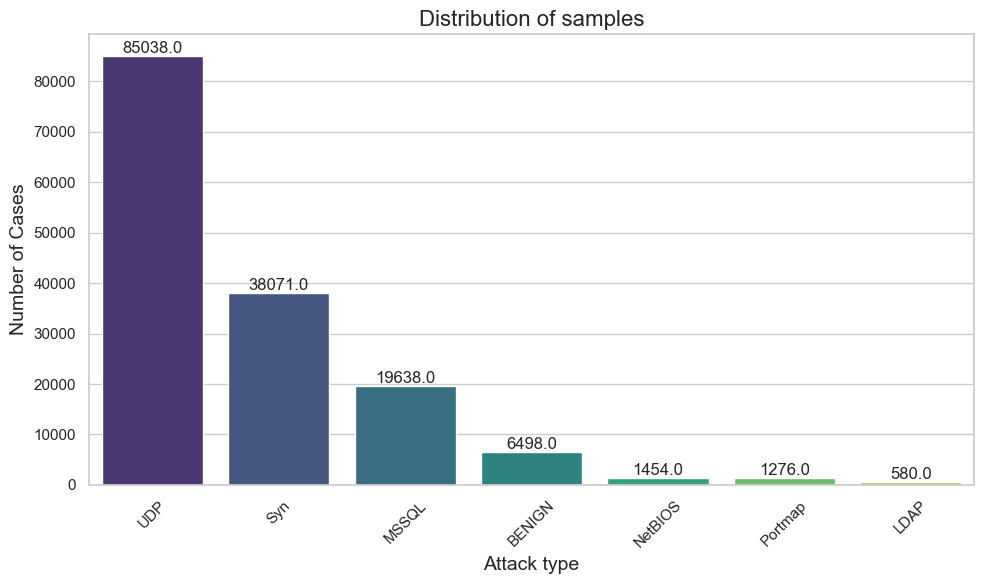

In [16]:
 visualize_labels(combined_df)

In [17]:
mapped_df = map_label(combined_df.copy())
# print(mapped_df['Label'].unique())

In [18]:
mapped_df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,17,1,2,0,422.0,0.0,211.0,211.0,211.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,17,48,2,0,530.0,0.0,265.0,265.0,265.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,17,1,2,0,494.0,0.0,247.0,247.0,247.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,17,2,2,0,494.0,0.0,247.0,247.0,247.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [19]:
label_distribution = calculate_label_distribution(mapped_df, 'Label')
display_label_distribution(label_distribution)

Samples Count: 6: 85038
Percentage distribution of data: 6: 55.74%
Samples Count: 5: 38071
Percentage distribution of data: 5: 24.96%
Samples Count: 3: 19638
Percentage distribution of data: 3: 12.87%
Samples Count: 0: 6498
Percentage distribution of data: 0: 4.26%
Samples Count: 1: 1454
Percentage distribution of data: 1: 0.95%
Samples Count: 4: 1276
Percentage distribution of data: 4: 0.84%
Samples Count: 2: 580
Percentage distribution of data: 2: 0.38%


# Visualization Data

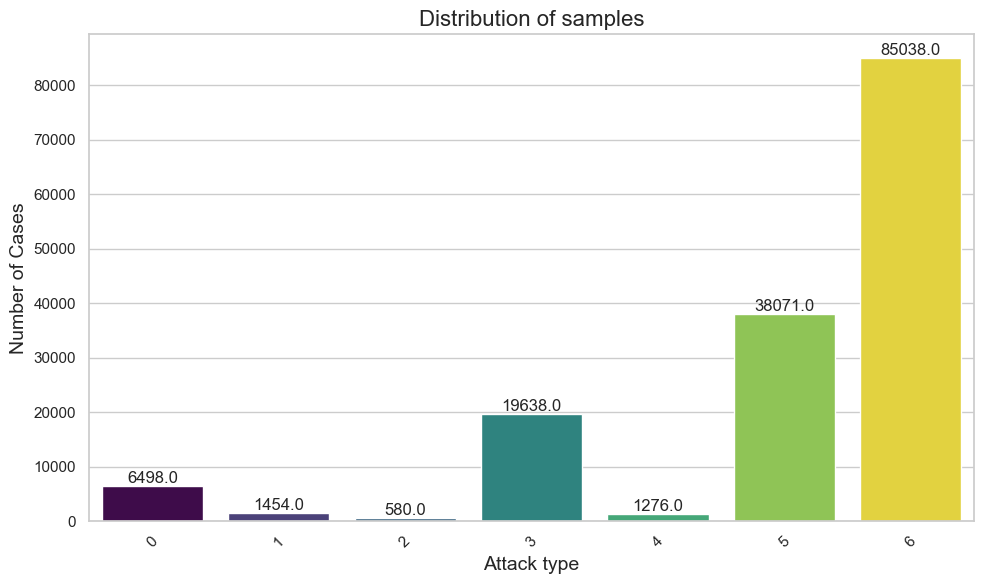

In [20]:
visualize_labels(mapped_df)

# Data splitting into training and test

In [21]:
## Feature and Target variable
X = mapped_df.drop('Label', axis=1)
y = mapped_df['Label']

## Always check dataset length
assert len(X) == len(y), "The lengths of feature sets and labels do not match."

In [22]:
## Split data into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [23]:
X_resampled, y_resampled = generate_smoth_samples(X_train, Y_train)

Class distribution after application of SMOTE:
Label
6    67977
5    67977
0    67977
3    67977
4    67977
1    67977
2    67977
Name: count, dtype: int64


# Training Model

## Random Forest


Algorytmy do rozważenia
Oprócz Random Forest, istnieje wiele innych algorytmów, które są znane jako dobre klasyfikatory wieloklasowe:

- Gradient Boosting Machines (GBM): Algorytmy takie jak XGBoost, LightGBM czy CatBoost są bardzo popularne w zadaniach klasyfikacyjnych i często osiągają lepsze wyniki niż tradycyjne metody.
  
- Support Vector Machines (SVM): SVM mogą być używane z różnymi jądrami do klasyfikacji wieloklasowej.

- K-nearest neighbors (KNN): Prosty, ale skuteczny algorytm, który działa dobrze w przypadku małych zbiorów danych.
  
- Neural Networks: Sieci neuronowe, zwłaszcza w kontekście głębokiego uczenia, mogą być bardzo skuteczne w klasyfikacji wieloklasowej.
  
- Naive Bayes: Dobry wybór dla problemów z dużą liczbą cech, zwłaszcza gdy dane są rozkładane normalnie.

In [26]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
time_execution(rf_model.fit, X_resampled, y_resampled)
rf_pred = rf_model.predict(X_test)
rf_pred

time execution: 0.4963 minut


array([6, 6, 3, ..., 6, 6, 5])

/var/folders/gp/tlttvkld1sz9z9htygrp2w3r0000gn/T/ipykernel_1472/3483310170.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/gp/tlttvkld1sz9z9htygrp2w3r0000gn/T/ipykernel_1472/3483310170.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/gp/tlttvkld1sz9z9htygrp2w3r0000gn/T/ipykernel_1472/3483310170.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/gp/tlttvkld1sz9z9htygrp2w3r0000gn/T/ipykernel_1472/3483310170.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is d

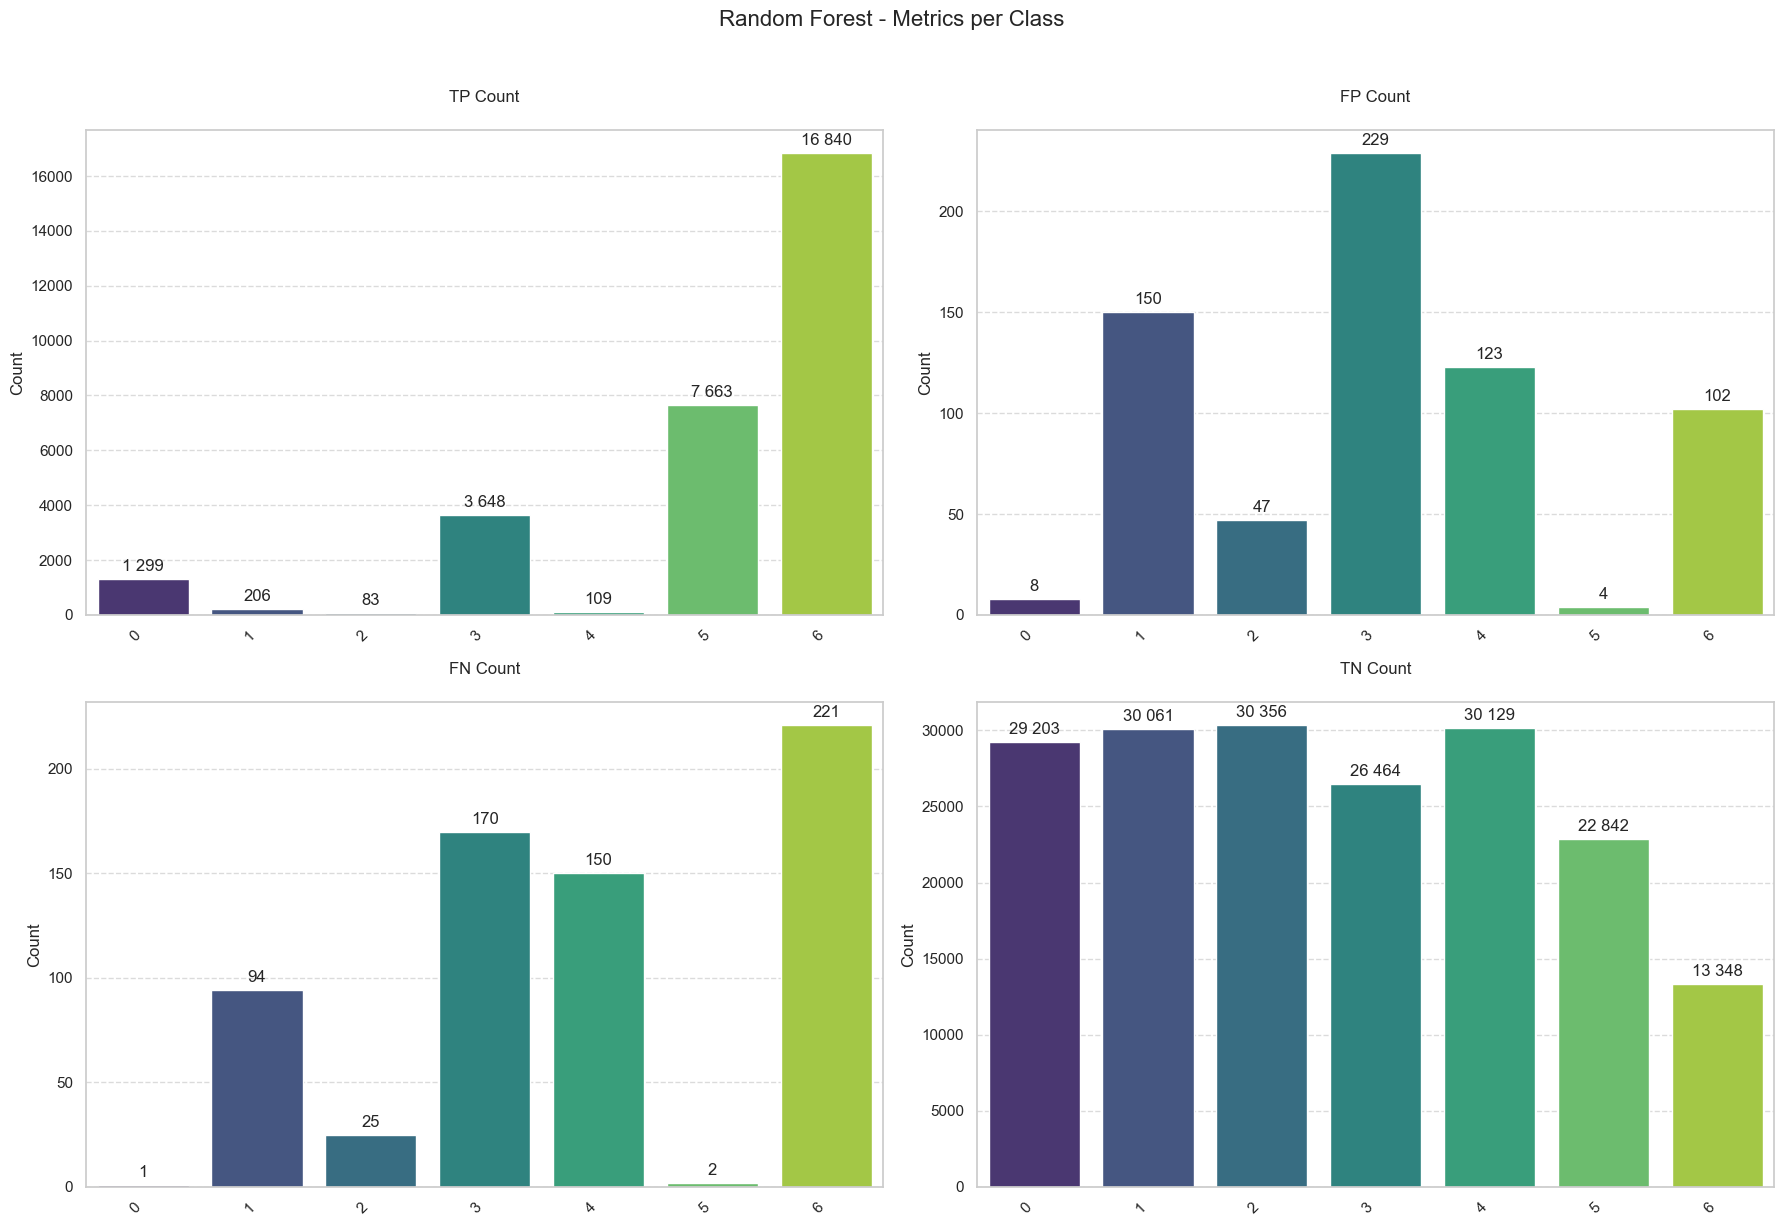

In [27]:
def visualize_rf_multiclass_metrics(y_true, y_pred, classes):
    # Oblicz macierz pomyłek
    cm = confusion_matrix(y_true, y_pred)
    
    # Przygotuj struktury danych
    metrics = []
    for i, class_name in enumerate(classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        
        metrics.append({
            'Class': class_name,
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'TN': tn
        })
    
    # Konwersja do DataFrame
    df_metrics = pd.DataFrame(metrics).melt(id_vars='Class', var_name='Metric', value_name='Count')
    
    # Konfiguracja wykresu
    plt.figure(figsize=(18, 12))
    plt.suptitle('Random Forest - Metrics per Class', y=1.02, fontsize=16)
    
    # Stwórz osobne subploty dla każdej metryki
    metrics_order = ['TP', 'FP', 'FN', 'TN']
    for i, metric in enumerate(metrics_order, 1):
        plt.subplot(2, 2, i)
        ax = sns.barplot(
            data=df_metrics[df_metrics['Metric'] == metric],
            x='Class',
            y='Count',
            palette='viridis'
        )
        
        # Dodaj adnotacje z wartościami
        for p in ax.patches:
            ax.annotate(
                f'{int(p.get_height()):,.0f}'.replace(',', ' '),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points'
            )
        
        plt.title(f'{metric} Count', pad=20)
        plt.xlabel('')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


visualize_rf_multiclass_metrics(Y_test, rf_pred, classes=rf_model.classes_)

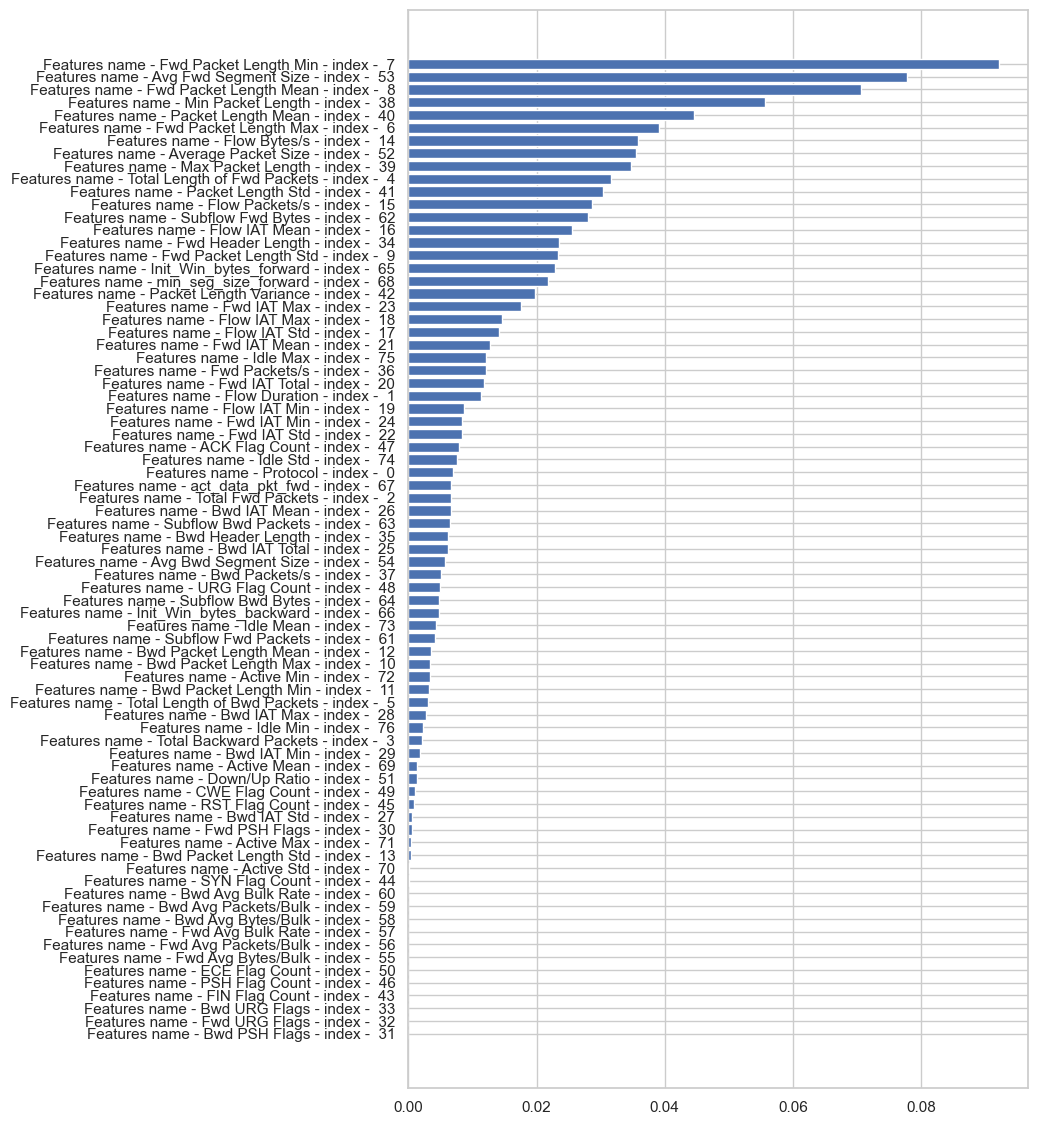

In [28]:
## importances feature from the model
show_importances_feature(X_train.shape[1], mapped_df, rf_model)

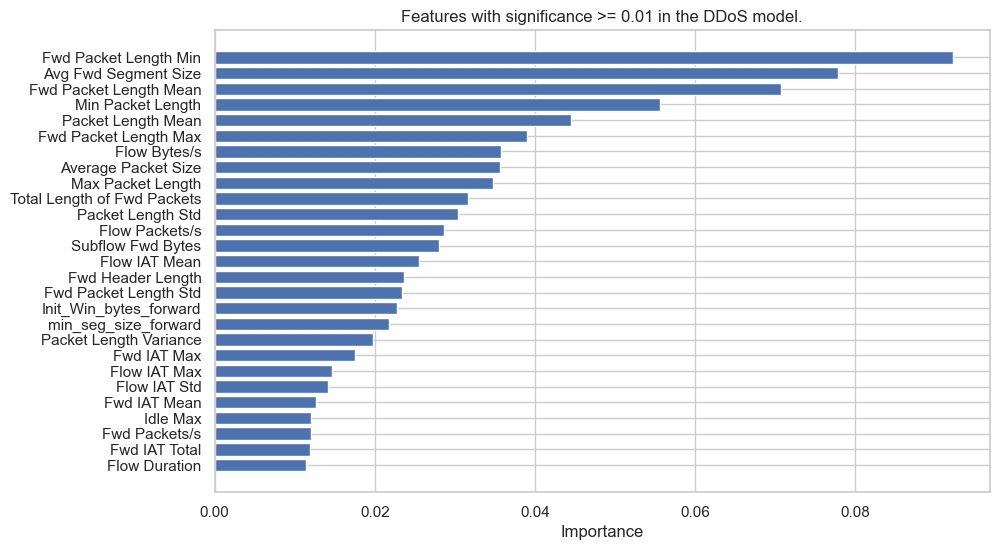

In [29]:
important_features_indices = extract_important_features(rf_model, mapped_df)

Wybór istotnych cech w modelu DDoS
Aby określić, które cechy są istotne dla modelu detekcji ataków DDoS, warto przyjąć pewien próg dla wartości ważności cech. W przypadku modeli opartych na drzewach decyzyjnych, takich jak Random Forest, można wykorzystać wartości ważności cech (feature importances) do oceny ich wpływu na model.

- Próg 0.05 (5%):
Cechy o ważności powyżej 5% są zazwyczaj uznawane za istotne. Ten próg jest często stosowany w praktyce i może pomóc w redukcji liczby cech do tych, które mają bardziej znaczący wpływ na wyniki modelu.

- Próg 0.1 (10%):
Cechy o ważności powyżej 10% są zdecydowanie istotne i powinny być brane pod uwagę w kolejnych iteracjach modelowania. Umożliwia to skoncentrowanie się na tych cechach, które mają największy wpływ na wydajność modelu.


- Próg 0.2 (20%):
Cechy o ważności powyżej 20% mogą być uznawane za kluczowe dla modelu. Wybór tylko tych cech może prowadzić do uproszczenia modelu i poprawy interpretowalności

In [31]:
# from sklearn.tree import plot_tree

# estimator = rf_model.estimators_[0]

# plt.figure(figsize=(20, 10))
# plot_tree(estimator, filled=True, rounded=True)

# plt.show()

# Model Evaluation

In [32]:
rf_accuracy = accuracy_score(Y_test, rf_pred)

rf_f1 = f1_score(Y_test, rf_pred, average='macro')
rf_precision = precision_score(Y_test, rf_pred, average='macro')
rf_recall = recall_score(Y_test, rf_pred, average='macro')

visualizationMetrics(rf_accuracy, rf_f1, rf_precision, rf_recall)

      Metric     Value
0   Accuracy  0.978270
1   F1 Score  0.814904
2  Precision  0.802173
3     Recall  0.831075


### Visualization

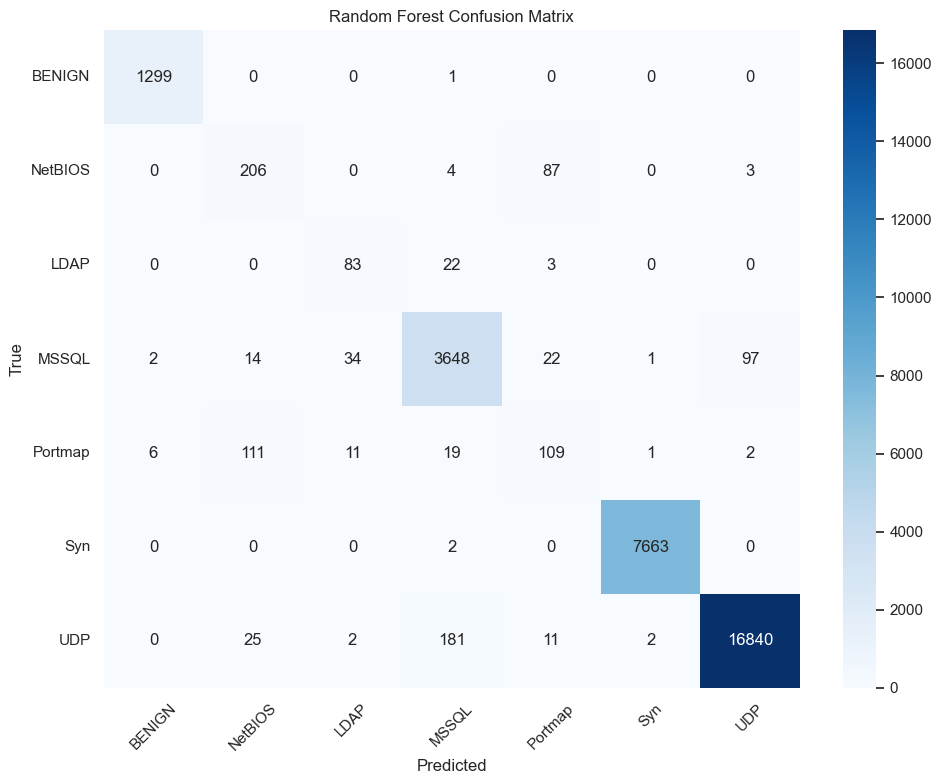

In [40]:
classes = ["BENIGN","NetBIOS", "LDAP", "MSSQL", "Portmap", "Syn", "UDP"]

plot_confusion_matrix(Y_test, rf_pred, classes, "Random Forest Confusion Matrix")

### Neural Network

In [41]:
nn_model = MLPClassifier(hidden_layer_sizes=(500,), max_iter=500, random_state=42)

time_execution(nn_model.fit, X_train, Y_train)
nn_pred = nn_model.predict(X_test)

time execution: 0.9375 minut


In [43]:
nn_accuracy = accuracy_score(Y_test, nn_pred)
nn_f1 = f1_score(Y_test, nn_pred, average='macro')
nn_precision = precision_score(Y_test, nn_pred, average='macro')
nn_recall = recall_score(Y_test, nn_pred, average='macro')


print(f"Accuracy: {nn_accuracy:.4f}")
print(f"F1 Score: {nn_f1:.4f}")
print(f"Precision: {nn_precision:.4f}")
print(f"Recall: {nn_recall:.4f}")

Accuracy: 0.6360
F1 Score: 0.3318
Precision: 0.7943
Recall: 0.3136


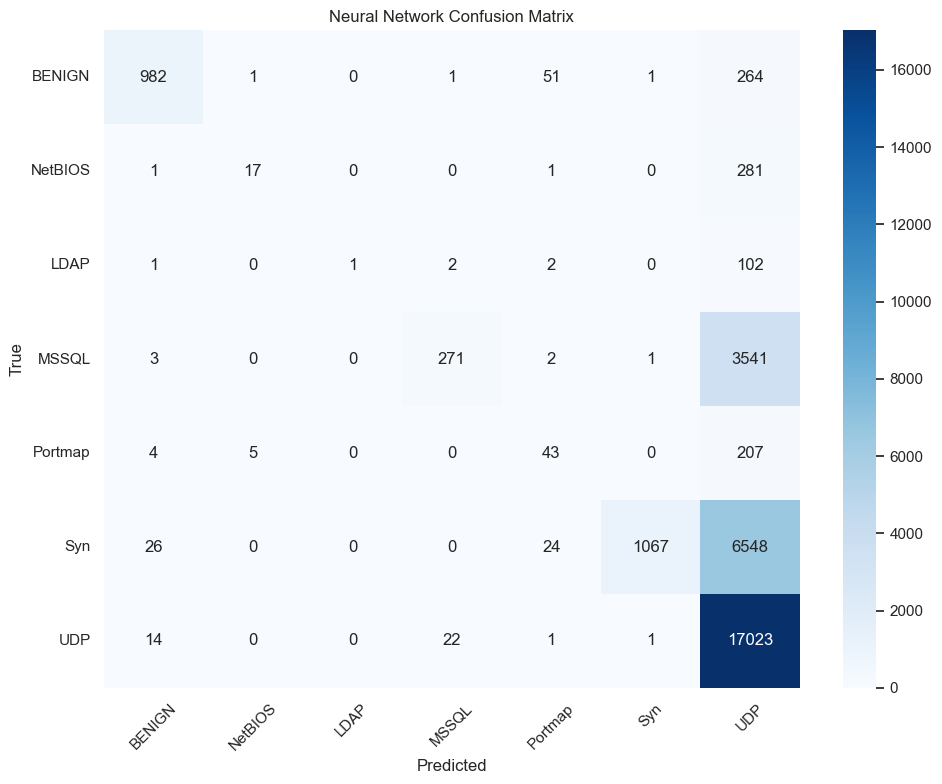

In [44]:
plot_confusion_matrix(Y_test, nn_pred, classes, "Neural Network Confusion Matrix")

In [162]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'hidden_layer_sizes': [(300,), (300, 150)],
#     'activation': ['relu', 'tanh'],
#     'alpha': [0.0001, 0.001],
#     'max_iter': [300, 500]
# }

# grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5)

# time_execution(grid_search.fit, X_train, Y_train)
# best_nn_model = grid_search.best_estimator_

# KNN

In [46]:
knn_model = KNeighborsClassifier(n_neighbors=4)

time_execution(knn_model.fit, X_resampled, y_resampled)

knn_pred = knn_model.predict(X_test)

time execution: 0.0028 minut


In [47]:
knn_accuracy = accuracy_score(Y_test, knn_pred)
knn_f1 = f1_score(Y_test, knn_pred, average='macro')
knn_precision = precision_score(Y_test, knn_pred, average='macro')
knn_recall = recall_score(Y_test, knn_pred, average='macro')

print(f"KNN Accuracy: {knn_accuracy:.4f}")
print(f"KNN F1 Score: {knn_f1:.4f}")
print(f"KNN Precision: {knn_precision:.4f}")
print(f"KNN Recall: {knn_recall:.4f}")

KNN Accuracy: 0.9609
KNN F1 Score: 0.7370
KNN Precision: 0.6994
KNN Recall: 0.8164


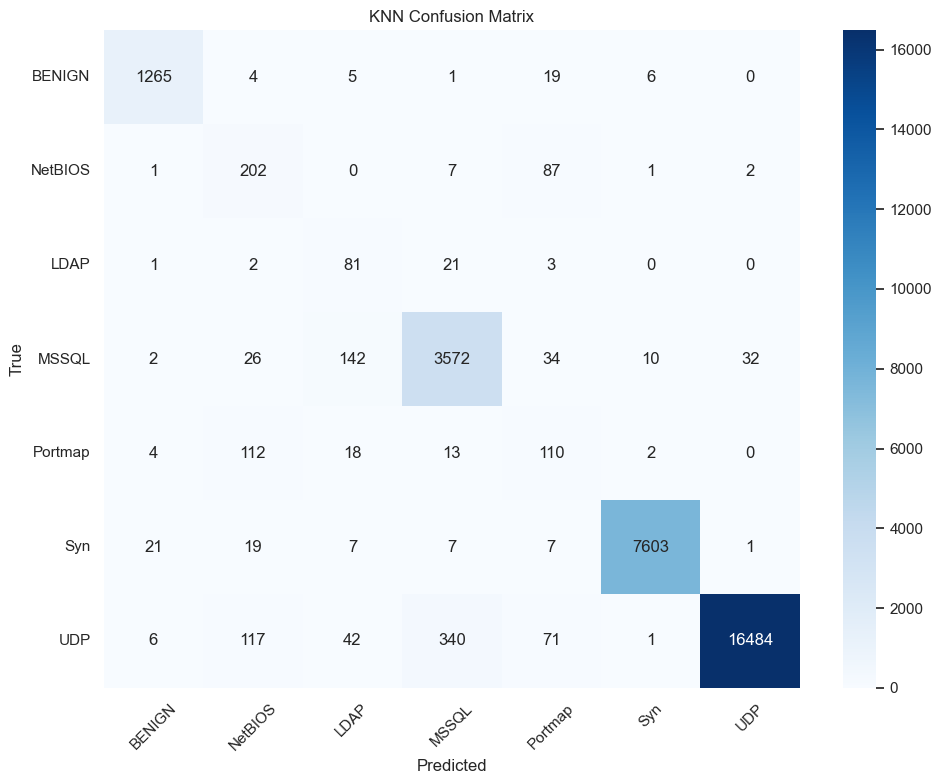

In [48]:
plot_confusion_matrix(Y_test, knn_pred, classes, "KNN Confusion Matrix")

KNN nie ma wbudowanej metody oceny istotności cech, ponieważ działa na zasadzie porównywania odległości między punktami w przestrzeni cech. Możesz jednak użyć kilku podejść, aby ocenić istotność cech:
Permutacyjna ważność cech: Możesz obliczyć dokładność modelu KNN na zbiorze testowym, a następnie permutować wartości jednej cechy i ponownie ocenić dokładność. Różnica w dokładności przed i po permutacji wskazuje na znaczenie tej cechy.

# Naive Bayes

In [132]:
nb_model = GaussianNB()

time_execution(nb_model.fit, X_resampled, y_resampled)

nb_pred = nb_model.predict(X_test)

time execution: 0.0060 minut


In [133]:
nb_accuracy = accuracy_score(Y_test, nb_pred)
nb_f1 = f1_score(Y_test, nb_pred, average='macro')
nb_precision = precision_score(Y_test, nb_pred, average='macro')
nb_recall = recall_score(Y_test, nb_pred, average='macro')

print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(f"Naive Bayes F1 Score: {nb_f1:.4f}")
print(f"Naive Bayes Precision: {nb_precision:.4f}")
print(f"Naive Bayes Recall: {nb_recall:.4f}")

Naive Bayes Accuracy: 0.8527
Naive Bayes F1 Score: 0.4257
Naive Bayes Precision: 0.6589
Naive Bayes Recall: 0.3926


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


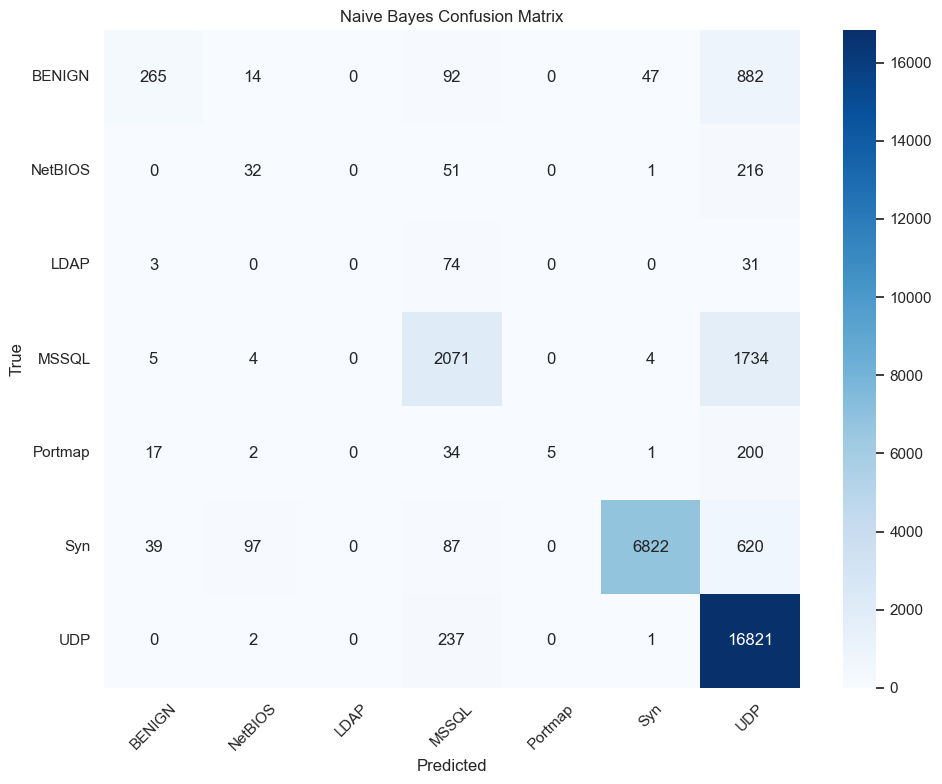

In [44]:
plot_confusion_matrix(Y_test, nb_pred, classes, "Naive Bayes Confusion Matrix")

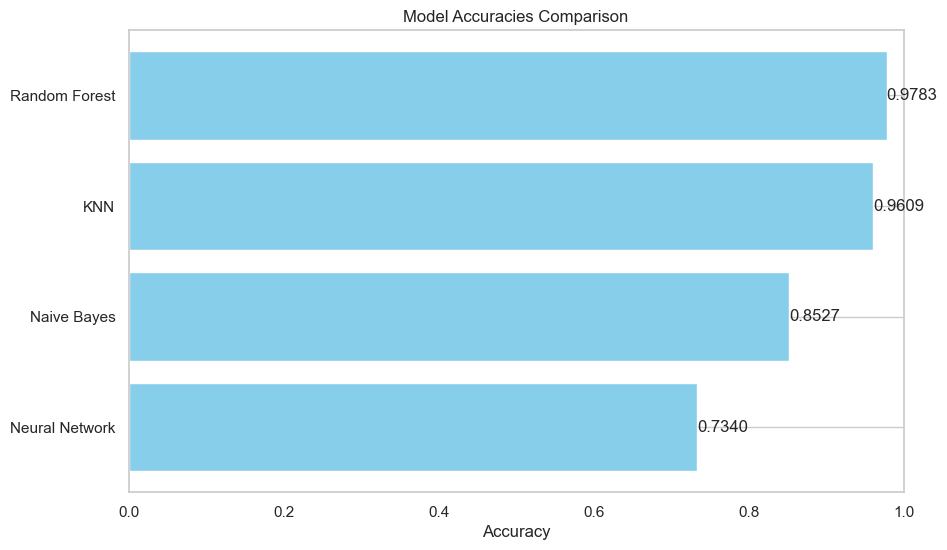

In [137]:
model_accuracies = {
    'Neural Network':  0.734,
    'Naive Bayes': nb_accuracy,
    'KNN': knn_accuracy,
    'Random Forest': rf_accuracy
}

visualize_model_accuracies(model_accuracies)

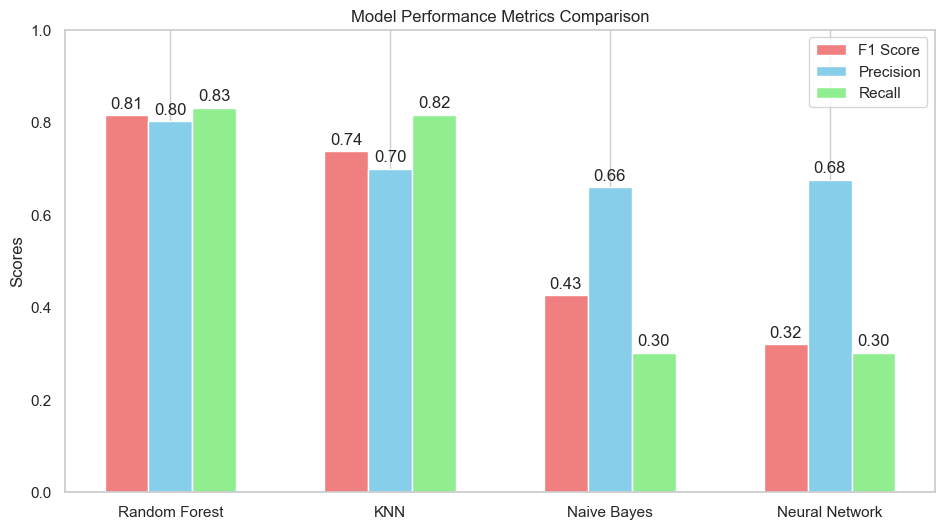

In [51]:
model_metrics = {
    'Random Forest': {'F1 Score': rf_f1, 'Precision': rf_precision, 'Recall': rf_recall},
    'KNN': {'F1 Score': knn_f1, 'Precision': knn_precision, 'Recall': knn_recall},
    'Naive Bayes': {'F1 Score': nb_f1, 'Precision': nb_precision, 'Recall': nn_recall},
    'Neural Network': {'F1 Score': nn_f1, 'Precision': nn_precision, 'Recall': nn_recall},
}

visualize_model_metrics(model_metrics)

### Zastosowanie technik optymalizacji - NN
Zastosowanie technik takich jak Grid Search do optymalizacji hiperparametrów może znacząco poprawić wyniki.

In [ ]:
# param_grid = {
#     'hidden_layer_sizes': [(300,), (500, )],
#     'activation': ['relu', 'tanh'],
#     'alpha': [0.0001, 0.001],
#     'max_iter': [300, 500]
# }

# grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5)
# grid_search.fit(X_train, Y_train)
# best_nn_model = grid_search.best_estimator_

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


# Re-learning

In [144]:
trimmed_dataset = trim_datataset(mapped_df, important_features_indices)

display_dataset_length(trimmed_dataset)

Dataset length: 152555


In [145]:
## Feature and Target variable
re_X = trimmed_dataset.drop('Label', axis=1)
re_Y = trimmed_dataset['Label']

## Always check dataset length
assert len(re_X) == len(re_Y), "The lengths of feature sets and labels do not match."

In [146]:
## Split data into training and testing set
re_X_train, re_X_test, re_Y_train, re_Y_test = train_test_split(re_X, re_Y, test_size=0.30, random_state=42)

## Check
re_train_persent = len(re_X_train) / len(trimmed_dataset) * 100
re_test_percent = len(re_X_test) / len(trimmed_dataset) * 100

print("Train", re_train_persent)
print("Test", re_test_percent)

Train 69.9996722493527
Test 30.00032775064731


In [149]:
time_execution(rf_model.fit, re_X_train, re_Y_train)
re_rf_pred = rf_model.predict(re_X_test)
re_rf_pred

time execution: 0.0653 minut


array([6, 6, 3, ..., 6, 5, 6])

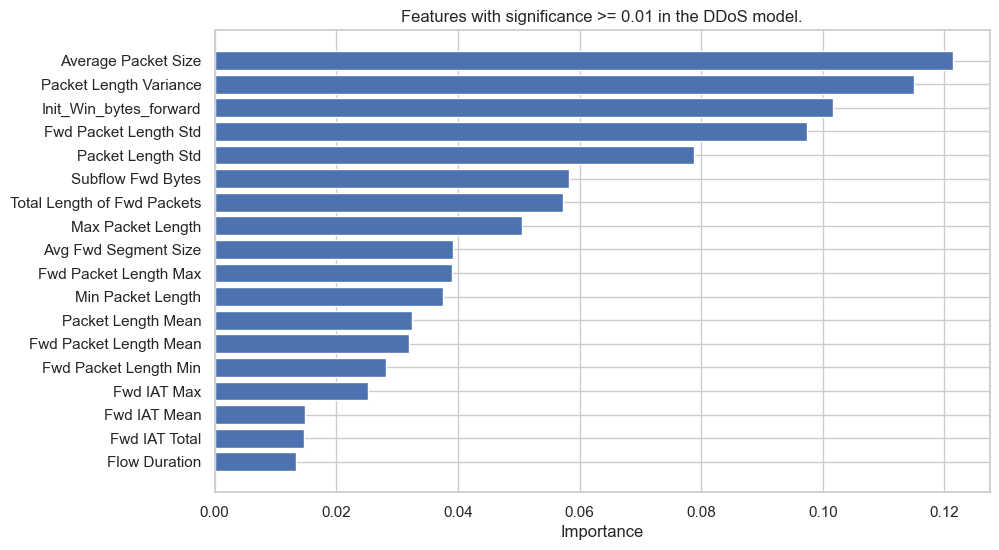

In [163]:
important_features_indices = extract_important_features(rf_model, trimmed_dataset)

In [152]:
new_rf_accuracy = accuracy_score(re_Y_test, re_rf_pred)

# Użycie 'macro' jako przykład
new_rf_f1 = f1_score(re_Y_test, re_rf_pred, average='macro')
new_rf_precision = precision_score(re_Y_test, re_rf_pred, average='macro')
new_rf_recall = recall_score(re_Y_test, re_rf_pred, average='macro')

In [164]:
print(f"Naive Bayes Accuracy: {new_rf_accuracy:.4f}")
print(f"Naive Bayes F1 Score: {new_rf_f1:.4f}")
print(f"Naive Bayes Precision: {new_rf_precision:.4f}")
print(f"Naive Bayes Recall: {new_rf_recall:.4f}")

Naive Bayes Accuracy: 0.9810
Naive Bayes F1 Score: 0.8308
Naive Bayes Precision: 0.8376
Naive Bayes Recall: 0.8248


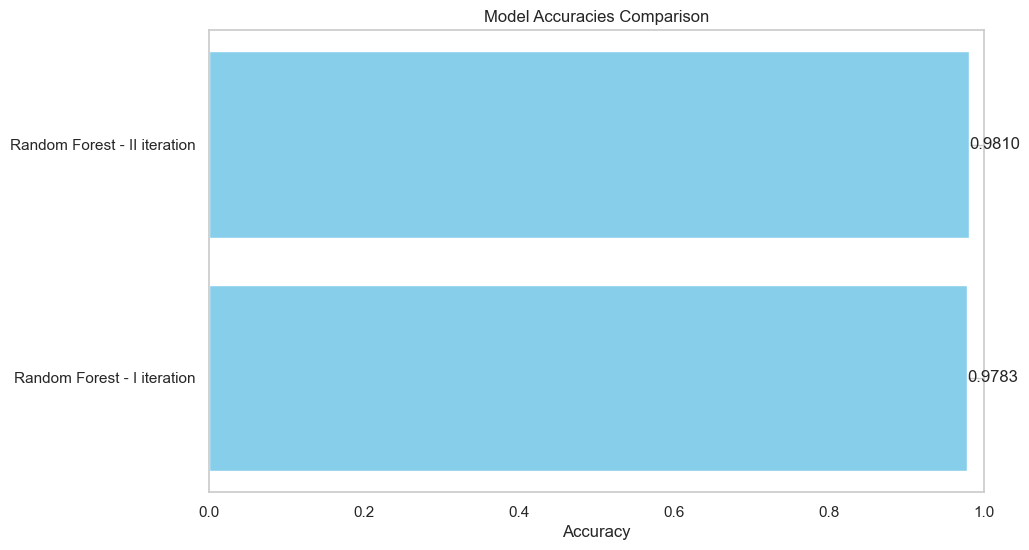

In [58]:
model_accuracies = {
    'Random Forest - I iteration': rf_accuracy,
    'Random Forest - II iteration': new_rf_accuracy,
}
visualize_model_accuracies(model_accuracies)

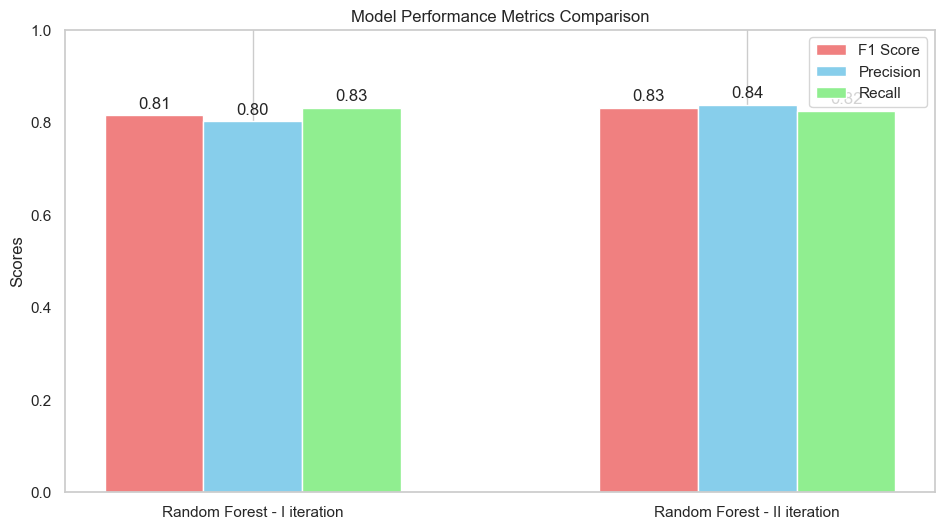

In [59]:
model_metrics = {
    'Random Forest - I iteration': {'F1 Score': rf_f1, 'Precision': rf_precision, 'Recall': rf_recall},
    'Random Forest - II iteration': {'F1 Score': new_rf_f1, 'Precision': new_rf_precision, 'Recall': new_rf_recall},
}

visualize_model_metrics(model_metrics)

Analiza wyników
- większenie dokładności (Accuracy):
Po przycięciu cech dokładność wzrosła z 97.83% do 98.10%. To sugeruje, że usunięcie mniej istotnych cech pozwoliło modelowi lepiej generalizować na zbiorze testowym.

- Poprawa F1 Score:
F1 Score wzrosła z 0.8149 do 0.8308, co wskazuje na lepszą równowagę między precyzją a czułością (recall). Jest to szczególnie ważne w kontekście problemów klasyfikacyjnych z nierównomiernym rozkładem klas.

- Zwiększenie precyzji:
Precyzja wzrosła z 80.22% do 83.76%. Oznacza to, że model stał się bardziej dokładny w przewidywaniu pozytywnych przypadków (prawdziwych pozytywów) w stosunku do wszystkich przewidywanych pozytywnych przypadków.


- Stabilność czułości:
Czułość spadła nieznacznie z 83.11% do 82.48%, co może sugerować, że model może nieco gorzej identyfikować niektóre pozytywne przypadki po przycięciu cech.


- Wnioski ogólne :

Przycinanie cech okazało się korzystne dla modelu Random Forest, co potwierdza hipotezę, że usunięcie mniej istotnych cech może poprawić wydajność modelu poprzez redukcję szumów i uproszczenie problemu klasyfikacji. Warto jednak zauważyć, że każda zmiana w zestawie cech powinna być dokładnie analizowana w kontekście konkretnego problemu i zbioru danych, aby upewnić się, że nie wpłynie negatywnie na zdolność modelu do identyfikacji istotnych wzorców w danych.

### Model Comparison

### Implementation of the ROC
 Użycie Krzywej ROC dla Klasyfikacji Wieloklasowej
Dla klasyfikacji wieloklasowej można zastosować jedną z dwóch popularnych metod:

- One-vs-Rest (OvR): Dla każdej klasy tworzony jest osobny model binarny, który odróżnia tę klasę od wszystkich pozostałych. Następnie obliczane są krzywe ROC dla każdego modelu.

- One-vs-One (OvO): Tworzenie modelu dla każdej pary klas. To podejście jest bardziej złożone i może być mniej wydajne w przypadku dużej liczby klas.

### Implementation of the ROC Curve with the One-vs-Rest Method

Funkcja plot_roc_curve ma kilka kluczowych zastosowań w kontekście ewaluacji modeli klasyfikacyjnych:

- Ocena wydajności modelu:

Krzywa ROC (Receiver Operating Characteristic) ilustruje zdolność modelu do rozróżniania między klasami. Im bliżej lewego górnego rogu wykresu znajduje się krzywa, tym lepsza jest wydajność modelu.

- Obliczanie AUC:

Pole pod krzywą ROC (AUC - Area Under the Curve) jest miarą ogólnej wydajności modelu. Wartość AUC wynosząca 1 oznacza idealny model, podczas gdy wartość 0.5 wskazuje na losowy klasyfikator.

- Porównanie modeli:

Dzięki wizualizacji krzywych ROC dla różnych modeli można łatwo porównać ich efektywność w rozróżnianiu klas.
Zrozumienie trade-offów: Krzywa ROC pozwala na zrozumienie kompromisu między wskaźnikami True Positive Rate (TPR) a False Positive Rate (FPR), co jest istotne w kontekście wyboru odpowiedniego progu decyzyjnego.

- Wizualizacja dla wielu klas:

Funkcja obsługuje wiele klas, co pozwala na ocenę wydajności modelu w kontekście klasyfikacji wieloklasowej.

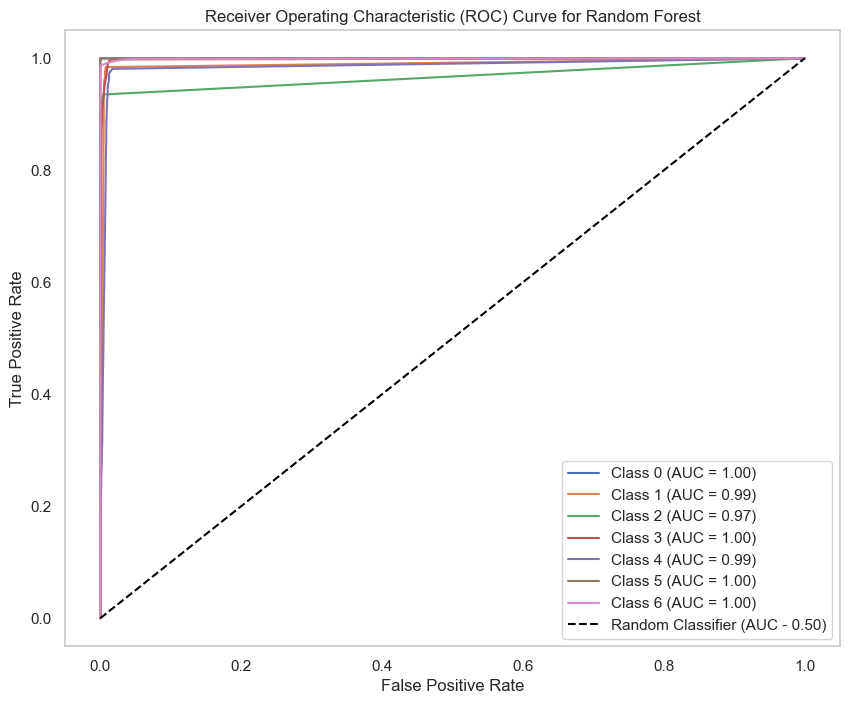

In [60]:
plot_roc_curve(rf_model, re_X_test, re_Y_test, "Random Forest")

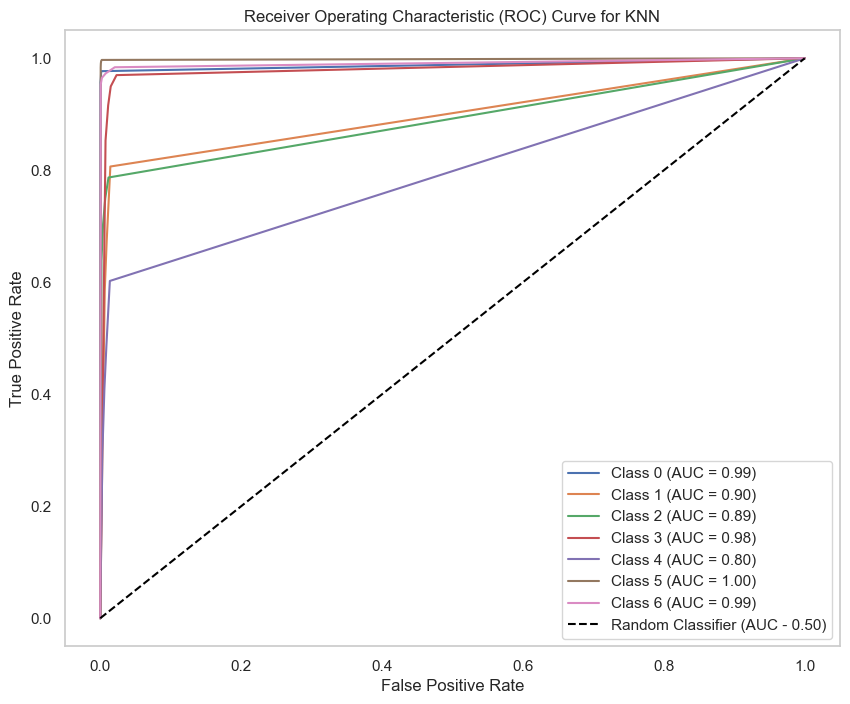

In [61]:
plot_roc_curve(knn_model, X_test, Y_test, "KNN")

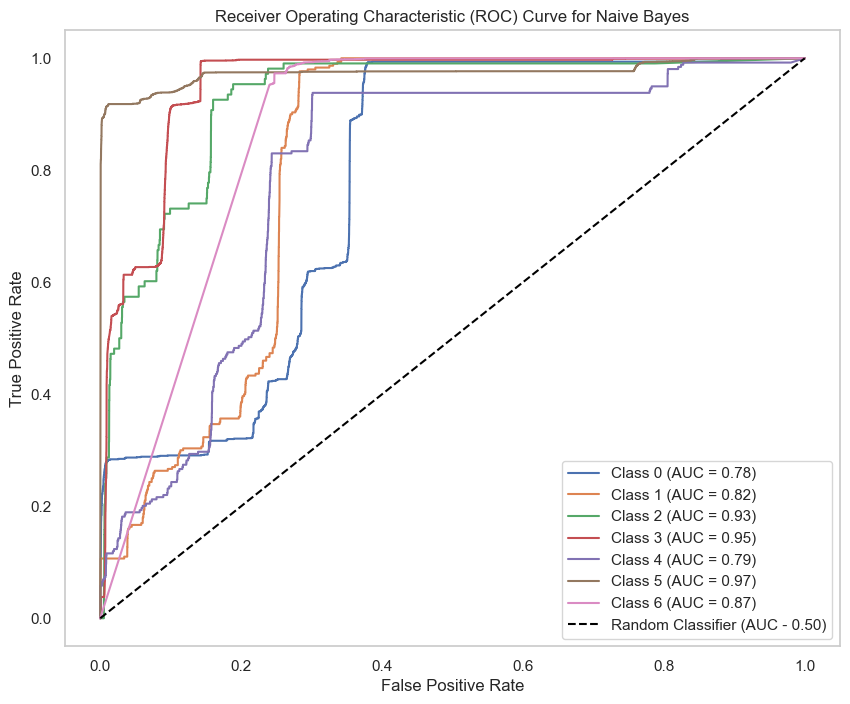

In [62]:
plot_roc_curve(nb_model, X_test, Y_test, "Naive Bayes")

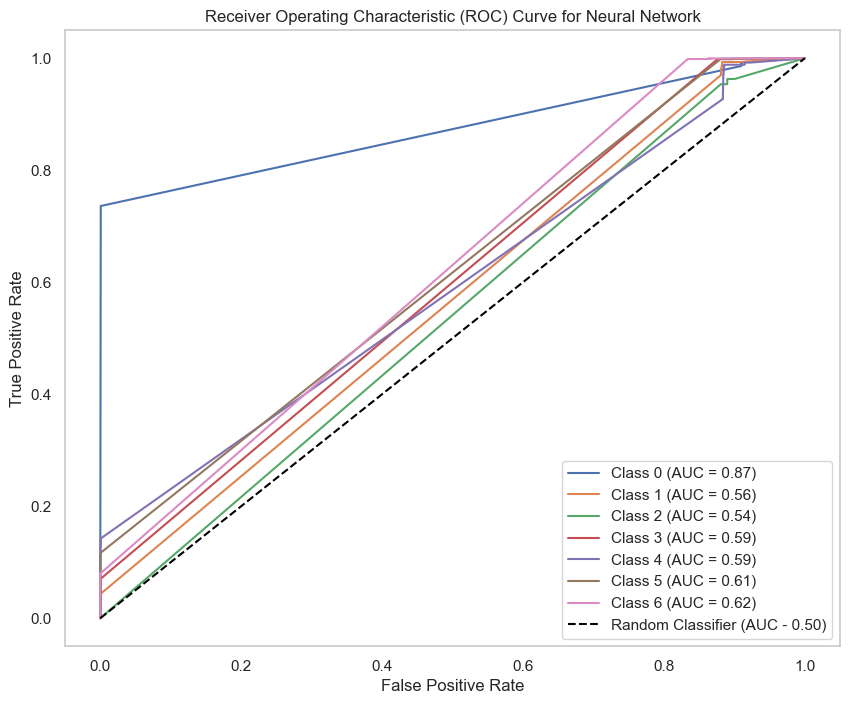

In [64]:
plot_roc_curve(nn_model, X_test, Y_test, "Neural Network")